# Generating Shakespeare Text

### Importing Libraries

In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import os
import time

### Downloading the Data

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 1s 1us/step


In [4]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [6]:
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

### Data Visualization

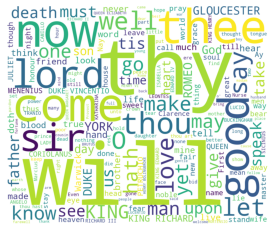

In [13]:
# WordCloud for the Shakespeare Text
wordcloud = WordCloud(background_color = 'white', width = 1200,
                            height = 1000).generate_from_text(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### Data Preprocessing

In [14]:
# getting vocabulary
vocab = sorted(set(text))

In [15]:
# Map char:index
char2idx = {u:i for i, u in enumerate(vocab)}

# Map index:char
idx2char = np.array(vocab)

In [19]:
# Convert text to corresponding idx
text_as_idx = np.array([char2idx[c] for c in text])

In [20]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_idx)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [23]:
sequences.element_spec

TensorSpec(shape=(101,), dtype=tf.int32, name=None)

In [22]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [24]:
# Split sequences into one-offset strings
dataset = sequences.map(split_input_target)

In [25]:
# Shuffling and Batching the Data

BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

### Building the Model with Stateful GRUs

In [26]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [27]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model = build_model(
        vocab_size = len(vocab),
        embedding_dim = embedding_dim,
        rnn_units = rnn_units,
        batch_size = BATCH_SIZE)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [29]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer="adam", loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [30]:
EPOCHS = 30 
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 387s 2s/step - loss: 2.6599
Epoch 2/30
172/172 [==============================] - 442s 3s/step - loss: 1.9606
Epoch 3/30
172/172 [==============================] - 478s 3s/step - loss: 1.6904
Epoch 4/30
172/172 [==============================] - 434s 3s/step - loss: 1.5429
Epoch 5/30
172/172 [==============================] - 421s 2s/step - loss: 1.4550
Epoch 6/30
172/172 [==============================] - 407s 2s/step - loss: 1.3932
Epoch 7/30
172/172 [==============================] - 407s 2s/step - loss: 1.3479
Epoch 8/30
172/172 [==============================] - 411s 2s/step - loss: 1.3075
Epoch 9/30
172/172 [==============================] - 432s 3s/step - loss: 1.2732
Epoch 10/30
172/172 [==============================] - 384s 2s/step - loss: 1.2401
Epoch 11/30
172/172 [==============================] - 383s 2s/step - loss: 1.2093
Epoch 12/30
172/172 [==============================] - 392s 2s/step - loss: 1.1769
Epoch 13/30
1

### Generating Texts

In [31]:
# Load last model

tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [32]:
def generate_text(model, start_string):
    len_gen = 25000
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text = []

    temp = 1.0

    model.reset_states()
    for i in range(len_gen):
        if (i % 5000 == 0):
            print("{0}/{1}".format(i, len_gen))
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temp 
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text.append(idx2char[predicted_id])
    return start_string + ''.join(text)


In [33]:
START_WORDS = [u"ROMEO: ", u"PUCK: ", u"MACBETH: ", u"HAMLET: ", u"IAGO: ", u"PROSPERO: ", u"LEAR: ", u"EDMUND: ", u"BENEDICK: "]
for word in START_WORDS:
    filename = "outputs/{0}_out.txt".format(word[:-2])
    print(word, filename)
    out_text = open(filename, "w+")
    out_text.write(generate_text(model, start_string = word))
    out_text.close()

ROMEO:  outputs/ROMEO_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
PUCK:  outputs/PUCK_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
MACBETH:  outputs/MACBETH_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
HAMLET:  outputs/HAMLET_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
IAGO:  outputs/IAGO_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
PROSPERO:  outputs/PROSPERO_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
LEAR:  outputs/LEAR_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
EDMUND:  outputs/EDMUND_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
BENEDICK:  outputs/BENEDICK_out.txt
0/25000
5000/25000
10000/25000
15000/25000
20000/25000
